<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/matt-sandbox/excitation-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/matt-sandbox/excitation-transfer.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Excitation transfer

This notebook is a first attempt at trying to observe an excitation transfer event using 2 two-state systems (we will also sometimes refer to them as particles) coupled to a field of harmonic oscillators

## Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qutip import *
warnings.filterwarnings('ignore')

## Transforming the two-state Hamiltonian

We have previously looked at a two state system whose base states **|+>** and **|->** were represented as

$$
|+> = \begin{bmatrix}
 1   \\
 0   \\
 \end{bmatrix}, 
|-> = \begin{bmatrix}
 0   \\
 1   \\
\end{bmatrix}
$$


In [3]:
plus = basis(2, 0)
minus = basis(2, 1)

and whose energies $E_0$ were identical. When we considered that coupling between the states could occur (with strength $A$), the hamiltonian for the system could then be represented as

$$
H = \begin{bmatrix}
 E_0  &  -A  \\
 -A  &  E_0  \\
\end{bmatrix} = E_0 I - A \sigma_x
$$

In [4]:
# We will continue to use parameters from the first tutorial
E0 = 1.0
A = 0.1
H = E0*qeye(2) - A*sigmax()

Upon investigating the time evolution of states using the above Hamiltonian, we have seen that the stationary states of the system are not |+> and |->, but instead

$\frac{|+> + \,\  |->}{\sqrt{2}}$ - in phase (a.k.a symmetric) - lower energy state

$\frac{|+> - \,\  |->}{\sqrt{2}}$ - out of phase (a.k.a anti-symmetric) - higher energy state



In [5]:
in_phase = (plus + minus).unit()
out_phase = (plus - minus).unit()

It is often convenient to represent the system in terms of its stationary states, i.e. use the stationary states to form a new basis. Let's see what the Hamiltonian looks like when we do this.

In [6]:
H.transform([out_phase,in_phase])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1.1 0. ]
 [0.  0.9]]

As we can see, the transformed Hamiltonian can be represented as 

$$
H = \begin{bmatrix}
 E_0+A  &  0  \\
 0  &  E_0-A  \\
\end{bmatrix} = E_0 I + A \sigma_z
$$

Because it is only energy differences that can be physically measured, $E_0$ is often set to zero for convenience. We will follow this convention for the rest of this notebook. Our two state Hamiltonian is then:

$$
H = \begin{bmatrix}
 A  &  0  \\
 0  &  -A  \\
\end{bmatrix} = A \sigma_z
$$

## Quantising the field

> TODO: Need to physically motivate the harmonic oscillator Hamiltonian

We'll begin with a single mode with energy (same as frequency, since $\hbar=1$) being a fraction of the two-state energy difference (which is $2A$).

In [7]:
N = 10                 # number of phonon quanta needed to exite the particle
E_phonon = 2*A / N     # phonon energy

We'll allow there to be a maximum of 2 quanta in that mode, i.e 2 phonons max, to begin with

In [140]:
M = 3                # M-1 is maximum number of phonons to simulate

## Interactions 

>TODO: Need to physically motivate the interaction terms in H

We'll begin with a strong coupling, i.e. $g\sim A$

In [141]:
g = 0.1

## Putting it all together 

> TODO: Some words on combining many systems together, motivate tensor product, etc

In [148]:
a  = tensor(destroy(M), qeye(2), qeye(2))  # phonon destruction operator
sm1 = tensor(qeye(M), sigmam(), qeye(2))   # sigma_minus operator for two-state system number 1 
sz1 = tensor(qeye(M), sigmaz(),  qeye(2))  # sigma_z for two-state system number 1 
sm2 = tensor(qeye(M), qeye(2), sigmam())   # sigma_minus operator for two-state system number 2
sz2 = tensor(qeye(M), qeye(2), sigmaz())   # sigma_z for two-state system number 2

In [149]:
two_state_1  =    A*sz1
two_state_2  =    A*sz2
phonons      =    E_phonon*a.dag()*a
interaction  =    g*(a.dag() + a) * (sm1 + sm1.dag()) + g*(a.dag() + a) * (sm2 + sm2.dag())

H = two_state_1 + two_state_2 + phonons + interaction

## Understanding the state vector

Now that we are using tensor products it can be a bit confusing to understand what everything means. Let's look at the dimensions for the Hamiltonian.

In [144]:
H.dims[0]

[3, 2, 2]

The first number tells us the number of different states the phonon field can be in (i.e. 0, 1 or 2 phonons). The other two numbers tell us the number of states that our two-systems can be in (obviously there are 2, the clue is in the name 😉).

The total number of states is given by 3x2x2 = 12. The amplitude for the system at any one time is therefore a vector of length 12 which conceptually can be represented as:

$$
\begin{bmatrix}
 0,+,+    \\
 0,+,-   \\
 0,-,+   \\
 0,-,-   \\
 1,+,+    \\
 1,+,-   \\
 1,-,+   \\
 1,-,-   \\
 2,+,+    \\
 2,+,-   \\
 2,-,+   \\
 2,-,-   \\
\end{bmatrix}
$$

Where the first number, i.e. 0,1 or 2, is the number of phonons in the field, the first ± represents the state of the first two state system, and the second ± represents the state of the second two state system.



In order to make plots easier to understand, we'll create a function to label the simulation data according to the notation described above.

In [135]:
def states_to_df(states,times):
    
    data = {}
    for i in range(0,states[0].shape[0]):
        which_mode = divmod(i,4)
        if which_mode[1] == 0:
            two_state = "+ , +"
        elif which_mode[1] == 1:
            two_state = "+ , -"
        elif which_mode[1] == 2:
            two_state = "- , +"
        else:
            two_state = "- , -"
        data[str(which_mode[0])+" , "+two_state] = np.zeros(len(times),dtype="complex128")
    
    for i, state in enumerate(states):
        for j, psi in enumerate(state):
            which_mode = divmod(j,4)
            if which_mode[1] == 0:
                two_state = "+ , +"
            elif which_mode[1] == 1:
                two_state = "+ , -"
            elif which_mode[1] == 2:
                two_state = "- , +"
            else:
                two_state = "- , -"
            data[str(which_mode[0])+" , "+two_state][i] = psi[0][0]

    return pd.DataFrame(data=data, index=times)

## Simulation

Excitation transfer in the context of our tensor product notation would correspond to the following change of state

$$
 \begin{bmatrix}
 0    \\
 1   \\
 0   \\
 0   \\
 0    \\
 0   \\
 0   \\
 0   \\
 0    \\
 0   \\
 0   \\
 0   \\
\end{bmatrix} 
 \rightarrow
\begin{bmatrix}
 0    \\
 0   \\
 1   \\
 0   \\
 0    \\
 0   \\
 0   \\
 0   \\
 0    \\
 0   \\
 0   \\
 0   \\
\end{bmatrix} 
$$

(ignoring phase factors like $e^{i\phi}$). 

We'll therefore need to set our initial state to be:

In [150]:
psi0 =  tensor(basis(M, 0), basis(2, 0), basis(2, 1))

i.e. we start off with no phonons, particle 1 in an excited (+) state and particle 2 in a lower energy (-) state.

Now we will solve the Schrödinger equation

In [151]:
times = np.linspace(0.0, 500.0, 10000) # simulation time
result = sesolve(H, psi0, times) 

In [152]:
df = states_to_df(result.states, times)

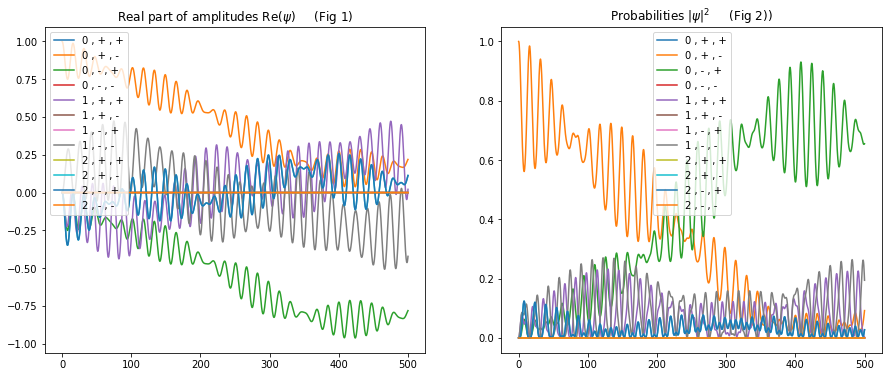

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)     (Fig 1)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 2))", ax=axes[1]);

From Fig 2 we can see that system starts off with particle number 1 excited (orange line) and over time the excitation is transfered to particle number 2 (green line). This transfer appears to have been mediated by phonons with much less energy than the transition energy of the particle - recall that:

In [111]:
E_phonon

0.02

In [19]:
# transition enegry
2*A

0.2

We must however also recall that so far $g=A$ and so there is a strong coupling between the two state systems and the field. It might be more physically realistic to took at the case where the coupling to the field is a small perturbation. We will proceed in the same way as we did in `02-perturbing-a-two-state-system`, i.e. set $g/A = 0.01 \ll 1$

### Weak coupling

We start by only changing the coupling strength and keep everything else the same

In [282]:
A = 0.1
N = 10                 # number of phonon quanta needed to exite the particle
E_phonon = 2*A / N     # phonon energy
M =  3                 # M-1 is maximum number of phonons to simulate
g = 0.001              # weak coupling

a  = tensor(destroy(M), qeye(2), qeye(2))  # phonon destruction operator
sm1 = tensor(qeye(M), sigmam(), qeye(2))   # sigma_minus operator for two-state system number 1 
sz1 = tensor(qeye(M), sigmaz(),  qeye(2))  # sigma_z for two-state system number 1 
sm2 = tensor(qeye(M), qeye(2), sigmam())   # sigma_minus operator for two-state system number 2
sz2 = tensor(qeye(M), qeye(2), sigmaz())   # sigma_z for two-state system number 2

two_state_1  =    A*sz1
two_state_2  =    A*sz2
phonons      =    E_phonon*a.dag()*a
interaction  =    g*(a.dag() + a) * (sm1 + sm1.dag()) + g*(a.dag() + a) * (sm2 + sm2.dag())

H = two_state_1 + two_state_2 + phonons + interaction

In [283]:
psi0 =  tensor(basis(M, 0), basis(2, 0), basis(2, 1))
times = np.linspace(0.0, 5000.0, 1000) # simulation time
result = sesolve(H, psi0, times) 
df = states_to_df(result.states, times)

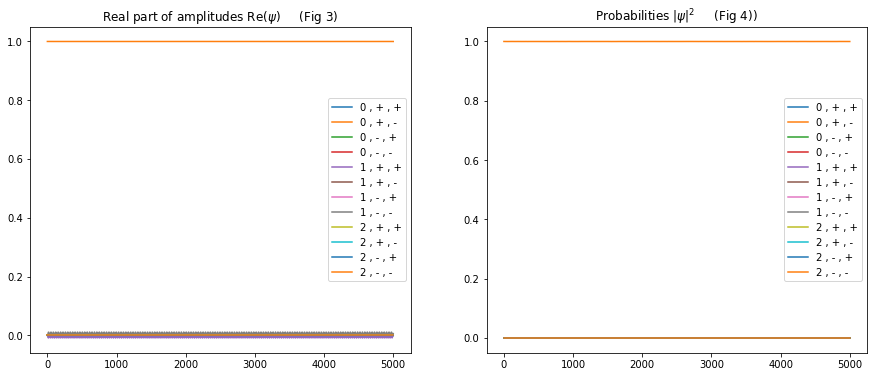

In [284]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)     (Fig 3)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 4))", ax=axes[1]);
plt.legend(loc="right");

Fig 4 shows us that no excitation transfer takes place. This is perhaps not so surprising because the frequency of the phonons is not resonant with the two state transition, i.e. $E_{phonon}  \neq 2A \equiv \omega_0$. We learnt in the last tutorial that being off resonance by just 1% had a profound affect on the dynamics - full transfer from one state to another did not occur. In the above simulation $|E_{phonon}-\omega_0| / \omega_0 = 90\%$!

We are however working with a quantised field now, so maybe things aren't quite the same. Let's try running the simulation for a longer time.

In [300]:
psi0 =  tensor(basis(M, 0), basis(2, 0), basis(2, 1))
times = np.linspace(0.0, 5000000.0, 10000) # simulation time
result = sesolve(H, psi0, times) 
df = states_to_df(result.states, times)

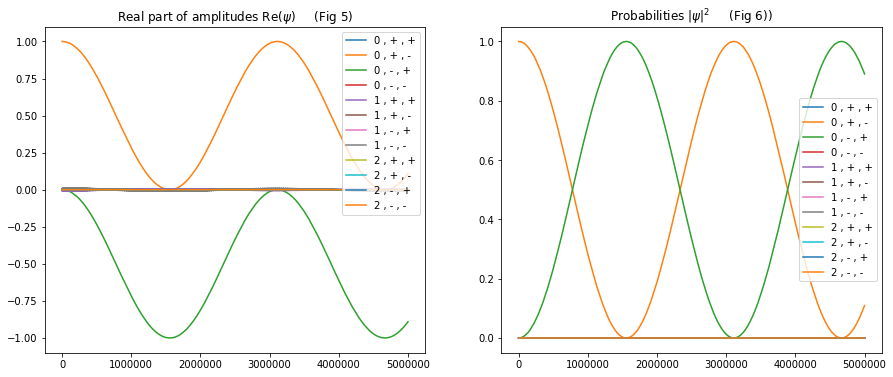

In [301]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)     (Fig 5)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 6))", ax=axes[1]);
plt.legend(loc="right");

Fig 6 seems to show that, even when the coupling is very weak, we can still get what we might call non-resonant excitation transfer - it just takes a long time. This is unlike the case in the previous tutorial where an off-resonant perturbation from an external (non quantised field) was not able to cause a complete transition form one state to another (see Fig 9). Note that we can the same result if we allow 19 phonons to be present, i.e. $M=20$ (it just takes a long time to run so we don't do it here).

We can look at the expectation values of the different parts of the Hamiltonian to give us more insight.

In [311]:
result = sesolve(H, psi0, times, [two_state_1, two_state_2, phonons, interaction]) 

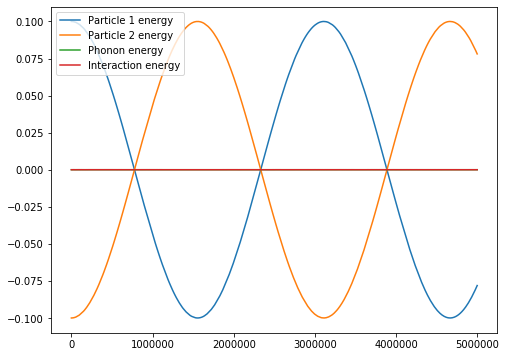

In [312]:
plt.figure(figsize=(8,6))
plt.plot(times,result.expect[0], label="Particle 1 energy")
plt.plot(times,result.expect[1], label="Particle 2 energy")
plt.plot(times,result.expect[2], label="Phonon energy")
plt.plot(times,result.expect[3], label="Interaction energy")
plt.legend();

We can hardly see the phonon, or interaction energy so let's look at them separately.

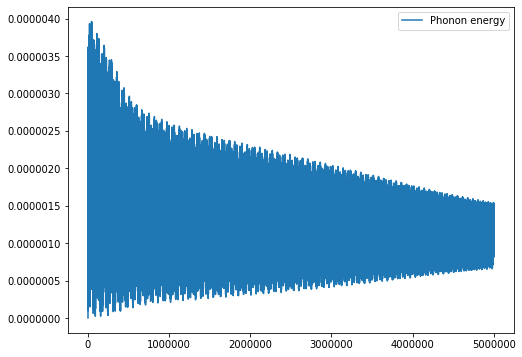

In [316]:
plt.figure(figsize=(8,6))
plt.plot(times,result.expect[2],  label="Phonon energy")
plt.legend();

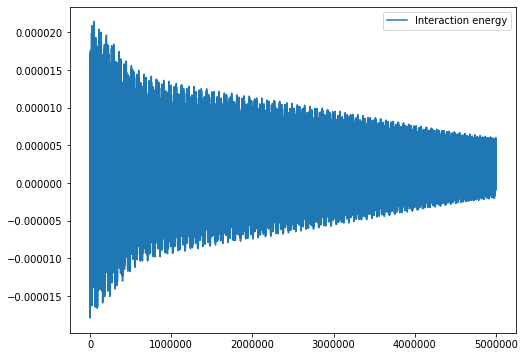

In [315]:
plt.figure(figsize=(8,6))
plt.plot(times,result.expect[3],  label="Interaction energy")
plt.legend();

The phonon and interaction energy are both very small. I'm not sure how to interpret this yet and whether it is physical.

... To be continued